<div align="center">

### Lab 4

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 4: Predicting Stock Price with Deep Learning

</div>

### Introduction

In this lab, we explore the application of time-series datasets using Long Short-Term Memory (LSTM) networks, a type of recurrent neural network, to predict stock prices. Specifically, we will use historical price data from Nvidia to forecast the stock's price for the next day based on the prices of the previous N days. This approach is particularly relevant given the volatile nature of stock markets and the increasing reliance on automated trading systems.

### Objectives

- To understand the fundamentals of LSTM networks and their application in time-series forecasting.
- To develop a predictive model that can accurately forecast Nvidia's stock price for the next day using historical data.

### Dataset

The dataset for this lab is from the "Huge Stock Market Dataset" available on Kaggle. This dataset includes daily prices and volumes for all US stocks and ETFs, with a specific focus on Nvidia (NVDA). The dataset features include:

- **Date**: The recorded data points.
- **Open**: The price at which the stock first traded upon the opening of an exchange on a given trading day.
- **High**: The highest price at which the stock traded during the trading day.
- **Low**: The lowest price at which the stock traded during the trading day.
- **Close**: The price of the stock at closing time.
- **Volume**: The number of shares or contracts traded in a security or an entire market during a given period.
- **OpenInt**: The total number of outstanding derivative contracts, like options or futures. [More details here](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/discussion/121096)

### References

- [Huge Stock Market Dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs) for the dataset used in this lab.


## A. Checking and Preprocessing

In [908]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import numpy as np

In [909]:
def set_seed(seed=1314520):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1314520)

In [910]:
# from google.colab import drive
# drive.mount('/content/drive')
file_paths = glob.glob('nvda.us.txt')

In [911]:
import pandas as pd

df = pd.read_csv('nvda.us.txt')
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-01-22,1.6238,1.8092,1.4379,1.5215,18297633,0
1,1999-01-25,1.6423,1.6980,1.5215,1.6793,3445279,0
2,1999-01-26,1.6980,1.7350,1.5311,1.5494,2320993,0
3,1999-01-27,1.5586,1.5957,1.4660,1.5494,1662658,0
4,1999-01-28,1.5494,1.5586,1.5311,1.5401,1540110,0
...,...,...,...,...,...,...,...
4728,2017-11-06,207.2000,209.9800,206.7000,209.6300,9731783,0
4729,2017-11-07,210.5500,212.9000,210.0560,212.0000,10671815,0
4730,2017-11-08,211.8500,212.0000,207.2400,209.1600,13033902,0
4731,2017-11-09,205.2700,206.3300,200.3700,205.3200,23895006,0


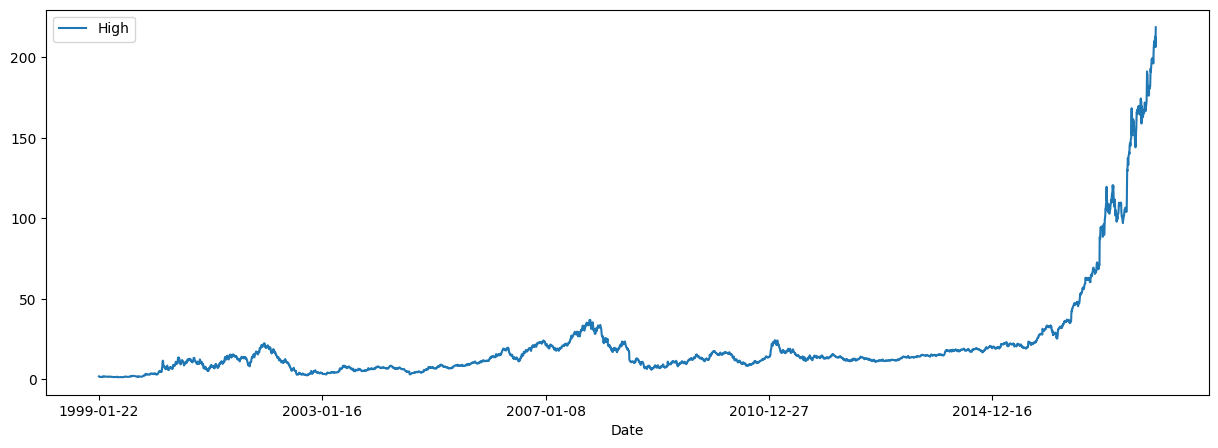

In [912]:
plot = df.plot('Date', 'High', figsize=(15, 5))

In [913]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')

In [914]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4733 entries, 0 to 4732
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     4733 non-null   object 
 1   Open     4733 non-null   float64
 2   High     4733 non-null   float64
 3   Low      4733 non-null   float64
 4   Close    4733 non-null   float64
 5   Volume   4733 non-null   int64  
 6   OpenInt  4733 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 259.0+ KB


In [915]:
# checking for null values
df.isnull().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

In [916]:
df = df.dropna()

In [917]:
df.shape

(4733, 7)

In [918]:
df.describe()

,Open,High,Low,Close,Volume,OpenInt
count,4733.000000,4733.000000,4733.000000,4733.000000,4.733000e+03,4733.0
mean,20.796242,21.157332,20.420417,20.805404,1.615287e+07,0.0
std,30.236284,30.615622,29.792958,30.263705,1.272446e+07,0.0
min,1.298900,1.317500,1.233900,1.261900,0.000000e+00,0.0
25%,7.988300,8.247900,7.756400,7.978900,8.181100e+06,0.0
50%,12.963000,13.238000,12.721000,12.990000,1.390271e+07,0.0
75%,19.141000,19.418000,18.778000,19.106000,2.051602e+07,0.0
max,213.080000,218.670000,211.630000,216.140000,2.496659e+08,0.0


#### Converting the DataFrame to a NumPy Array

In [920]:
def create_sequences(input_data, output_data, window_size, step):
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)

In [921]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

features = df[['Open', 'High', 'Low', 'Close', 'Volume']]
labels = df['High'].shift(-1)  # Next day's high price as label

X, y = create_sequences(features, labels, window_size=5, step=5)

print(f'Shape of data X: {X.shape}')
print(f'Shape of data y: {y.shape}')

# split the hold-out tests
ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int) # 10% hold-out
x_test = X[ind]
y_test = y[ind]
all_ind = np.arange(len(X))
remains_ind = np.delete(all_ind, ind)

X = X[remains_ind]
y = y[remains_ind]

# shuffle dataset
ind = np.random.permutation(len(X))
X = X[ind]
y = y[ind]
split_point = int(X.shape[0]*0.8)

x_train = X[:split_point]
y_train = y[:split_point]
x_val = X[split_point:]
y_val = y[split_point:]

print(f'Shape of data x_train: {x_train.shape}')
print(f'Shape of data y_train: {y_train.shape}')
print(f'Shape of data x_val: {x_val.shape}')
print(f'Shape of data y_val: {y_val.shape}')
print(f'Shape of data x_test: {x_test.shape}')
print(f'Shape of data y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

Shape of data X: (946, 5, 5)
Shape of data y: (946,)
Shape of data x_train: (681, 5, 5)
Shape of data y_train: (681,)
Shape of data x_val: (171, 5, 5)
Shape of data y_val: (171,)
Shape of data x_test: (94, 5, 5)
Shape of data y_test: (94,)
Number of samples in training and validation are 681 and 171.


## B. Defining Neural Networks

In [922]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

## C. Training the Neural Network

In [923]:
# Check your GPU status.
!nvidia-smi

Wed Apr 30 15:09:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.61                 Driver Version: 572.61         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   50C    P8             18W /  170W |    1554MiB /  12288MiB |     13%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [924]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []

epochs = 100

input_dim = X.shape[-1]

model = LSTMModel(input_dim = input_dim, hidden_dim=500, num_layers=2, output_dim=1).cuda()
print(model)

best_val_loss = float('inf')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning rate update
    lr_scheduler.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')



    # Store performance
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')

# print(f'Training completed. Best Validation MSE: {best_val_loss:.4f}')

LSTMModel(
  (lstm): LSTM(5, 500, num_layers=2, batch_first=True)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


  3%|▎         | 3/100 [00:00<00:13,  7.23it/s]

Epoch 1/100, Train loss: 0.2049, Val loss: 0.0864, Best Val loss: 0.0864
Epoch 2/100, Train loss: 0.0224, Val loss: 0.0199, Best Val loss: 0.0199
Epoch 3/100, Train loss: 0.0132, Val loss: 0.0195, Best Val loss: 0.0195


  5%|▌         | 5/100 [00:00<00:10,  9.18it/s]

Epoch 4/100, Train loss: 0.0138, Val loss: 0.0126, Best Val loss: 0.0126
Epoch 5/100, Train loss: 0.0091, Val loss: 0.0135, Best Val loss: 0.0126
Epoch 6/100, Train loss: 0.0119, Val loss: 0.0093, Best Val loss: 0.0093


  9%|▉         | 9/100 [00:00<00:07, 11.38it/s]

Epoch 7/100, Train loss: 0.0088, Val loss: 0.0078, Best Val loss: 0.0078
Epoch 8/100, Train loss: 0.0061, Val loss: 0.0096, Best Val loss: 0.0078
Epoch 9/100, Train loss: 0.0049, Val loss: 0.0206, Best Val loss: 0.0078


 11%|█         | 11/100 [00:01<00:07, 12.05it/s]

Epoch 10/100, Train loss: 0.0456, Val loss: 0.0114, Best Val loss: 0.0078
Epoch 11/100, Train loss: 0.0438, Val loss: 0.0197, Best Val loss: 0.0078
Epoch 12/100, Train loss: 0.0122, Val loss: 0.0099, Best Val loss: 0.0078


 15%|█▌        | 15/100 [00:01<00:06, 12.32it/s]

Epoch 13/100, Train loss: 0.0094, Val loss: 0.0100, Best Val loss: 0.0078
Epoch 14/100, Train loss: 0.0068, Val loss: 0.0075, Best Val loss: 0.0075
Epoch 15/100, Train loss: 0.0052, Val loss: 0.0057, Best Val loss: 0.0057


 17%|█▋        | 17/100 [00:01<00:06, 12.80it/s]

Epoch 16/100, Train loss: 0.0108, Val loss: 0.0075, Best Val loss: 0.0057
Epoch 17/100, Train loss: 0.0071, Val loss: 0.0080, Best Val loss: 0.0057
Epoch 18/100, Train loss: 0.0039, Val loss: 0.0069, Best Val loss: 0.0057


 21%|██        | 21/100 [00:01<00:06, 13.06it/s]

Epoch 19/100, Train loss: 0.0042, Val loss: 0.0065, Best Val loss: 0.0057
Epoch 20/100, Train loss: 0.0046, Val loss: 0.0061, Best Val loss: 0.0057
Epoch 21/100, Train loss: 0.0030, Val loss: 0.0086, Best Val loss: 0.0057


 23%|██▎       | 23/100 [00:01<00:05, 13.27it/s]

Epoch 22/100, Train loss: 0.0072, Val loss: 0.0086, Best Val loss: 0.0057
Epoch 23/100, Train loss: 0.0133, Val loss: 0.0101, Best Val loss: 0.0057
Epoch 24/100, Train loss: 0.0067, Val loss: 0.0100, Best Val loss: 0.0057


 27%|██▋       | 27/100 [00:02<00:05, 12.83it/s]

Epoch 25/100, Train loss: 0.0058, Val loss: 0.0070, Best Val loss: 0.0057
Epoch 26/100, Train loss: 0.0044, Val loss: 0.0051, Best Val loss: 0.0051
Epoch 27/100, Train loss: 0.0036, Val loss: 0.0050, Best Val loss: 0.0050


 29%|██▉       | 29/100 [00:02<00:05, 12.99it/s]

Epoch 28/100, Train loss: 0.0037, Val loss: 0.0083, Best Val loss: 0.0050
Epoch 29/100, Train loss: 0.0251, Val loss: 0.0271, Best Val loss: 0.0050
Epoch 30/100, Train loss: 0.0118, Val loss: 0.0063, Best Val loss: 0.0050


 33%|███▎      | 33/100 [00:02<00:05, 12.90it/s]

Epoch 31/100, Train loss: 0.0045, Val loss: 0.0062, Best Val loss: 0.0050
Epoch 32/100, Train loss: 0.0029, Val loss: 0.0048, Best Val loss: 0.0048
Epoch 33/100, Train loss: 0.0030, Val loss: 0.0046, Best Val loss: 0.0046


 35%|███▌      | 35/100 [00:02<00:04, 13.12it/s]

Epoch 34/100, Train loss: 0.0025, Val loss: 0.0061, Best Val loss: 0.0046
Epoch 35/100, Train loss: 0.0030, Val loss: 0.0055, Best Val loss: 0.0046
Epoch 36/100, Train loss: 0.0039, Val loss: 0.0058, Best Val loss: 0.0046


 39%|███▉      | 39/100 [00:03<00:04, 13.10it/s]

Epoch 37/100, Train loss: 0.0049, Val loss: 0.0057, Best Val loss: 0.0046
Epoch 38/100, Train loss: 0.0038, Val loss: 0.0042, Best Val loss: 0.0042
Epoch 39/100, Train loss: 0.0031, Val loss: 0.0043, Best Val loss: 0.0042


 41%|████      | 41/100 [00:03<00:04, 13.33it/s]

Epoch 40/100, Train loss: 0.0028, Val loss: 0.0053, Best Val loss: 0.0042
Epoch 41/100, Train loss: 0.0025, Val loss: 0.0048, Best Val loss: 0.0042
Epoch 42/100, Train loss: 0.0029, Val loss: 0.0040, Best Val loss: 0.0040


 45%|████▌     | 45/100 [00:03<00:04, 13.26it/s]

Epoch 43/100, Train loss: 0.0026, Val loss: 0.0066, Best Val loss: 0.0040
Epoch 44/100, Train loss: 0.0028, Val loss: 0.0050, Best Val loss: 0.0040
Epoch 45/100, Train loss: 0.0030, Val loss: 0.0045, Best Val loss: 0.0040


 47%|████▋     | 47/100 [00:03<00:03, 13.29it/s]

Epoch 46/100, Train loss: 0.0030, Val loss: 0.0054, Best Val loss: 0.0040
Epoch 47/100, Train loss: 0.0026, Val loss: 0.0049, Best Val loss: 0.0040
Epoch 48/100, Train loss: 0.0027, Val loss: 0.0064, Best Val loss: 0.0040


 51%|█████     | 51/100 [00:04<00:03, 13.15it/s]

Epoch 49/100, Train loss: 0.0024, Val loss: 0.0039, Best Val loss: 0.0039
Epoch 50/100, Train loss: 0.0033, Val loss: 0.0092, Best Val loss: 0.0039
Epoch 51/100, Train loss: 0.0031, Val loss: 0.0048, Best Val loss: 0.0039


 53%|█████▎    | 53/100 [00:04<00:03, 13.33it/s]

Epoch 52/100, Train loss: 0.0025, Val loss: 0.0046, Best Val loss: 0.0039
Epoch 53/100, Train loss: 0.0026, Val loss: 0.0043, Best Val loss: 0.0039
Epoch 54/100, Train loss: 0.0024, Val loss: 0.0035, Best Val loss: 0.0035


 57%|█████▋    | 57/100 [00:04<00:03, 12.92it/s]

Epoch 55/100, Train loss: 0.0029, Val loss: 0.0039, Best Val loss: 0.0035
Epoch 56/100, Train loss: 0.0024, Val loss: 0.0035, Best Val loss: 0.0035
Epoch 57/100, Train loss: 0.0023, Val loss: 0.0035, Best Val loss: 0.0035


 59%|█████▉    | 59/100 [00:04<00:03, 13.12it/s]

Epoch 58/100, Train loss: 0.0023, Val loss: 0.0037, Best Val loss: 0.0035
Epoch 59/100, Train loss: 0.0029, Val loss: 0.0041, Best Val loss: 0.0035
Epoch 60/100, Train loss: 0.0029, Val loss: 0.0038, Best Val loss: 0.0035


 63%|██████▎   | 63/100 [00:05<00:02, 13.36it/s]

Epoch 61/100, Train loss: 0.0026, Val loss: 0.0037, Best Val loss: 0.0035
Epoch 62/100, Train loss: 0.0026, Val loss: 0.0039, Best Val loss: 0.0035
Epoch 63/100, Train loss: 0.0020, Val loss: 0.0046, Best Val loss: 0.0035


 65%|██████▌   | 65/100 [00:05<00:02, 13.00it/s]

Epoch 64/100, Train loss: 0.0019, Val loss: 0.0033, Best Val loss: 0.0033
Epoch 65/100, Train loss: 0.0020, Val loss: 0.0033, Best Val loss: 0.0033
Epoch 66/100, Train loss: 0.0023, Val loss: 0.0032, Best Val loss: 0.0032


 69%|██████▉   | 69/100 [00:05<00:02, 13.23it/s]

Epoch 67/100, Train loss: 0.0022, Val loss: 0.0046, Best Val loss: 0.0032
Epoch 68/100, Train loss: 0.0023, Val loss: 0.0075, Best Val loss: 0.0032
Epoch 69/100, Train loss: 0.0025, Val loss: 0.0039, Best Val loss: 0.0032


 71%|███████   | 71/100 [00:05<00:02, 13.20it/s]

Epoch 70/100, Train loss: 0.0021, Val loss: 0.0048, Best Val loss: 0.0032
Epoch 71/100, Train loss: 0.0023, Val loss: 0.0032, Best Val loss: 0.0032
Epoch 72/100, Train loss: 0.0024, Val loss: 0.0042, Best Val loss: 0.0032


 75%|███████▌  | 75/100 [00:05<00:01, 12.95it/s]

Epoch 73/100, Train loss: 0.0023, Val loss: 0.0035, Best Val loss: 0.0032
Epoch 74/100, Train loss: 0.0020, Val loss: 0.0031, Best Val loss: 0.0031
Epoch 75/100, Train loss: 0.0025, Val loss: 0.0032, Best Val loss: 0.0031


 77%|███████▋  | 77/100 [00:06<00:01, 13.17it/s]

Epoch 76/100, Train loss: 0.0021, Val loss: 0.0039, Best Val loss: 0.0031
Epoch 77/100, Train loss: 0.0019, Val loss: 0.0032, Best Val loss: 0.0031
Epoch 78/100, Train loss: 0.0019, Val loss: 0.0038, Best Val loss: 0.0031


 81%|████████  | 81/100 [00:06<00:01, 13.12it/s]

Epoch 79/100, Train loss: 0.0022, Val loss: 0.0037, Best Val loss: 0.0031
Epoch 80/100, Train loss: 0.0019, Val loss: 0.0031, Best Val loss: 0.0031
Epoch 81/100, Train loss: 0.0018, Val loss: 0.0038, Best Val loss: 0.0031


 83%|████████▎ | 83/100 [00:06<00:01, 13.28it/s]

Epoch 82/100, Train loss: 0.0019, Val loss: 0.0036, Best Val loss: 0.0031
Epoch 83/100, Train loss: 0.0019, Val loss: 0.0033, Best Val loss: 0.0031
Epoch 84/100, Train loss: 0.0018, Val loss: 0.0035, Best Val loss: 0.0031


 87%|████████▋ | 87/100 [00:06<00:00, 13.55it/s]

Epoch 85/100, Train loss: 0.0019, Val loss: 0.0036, Best Val loss: 0.0031
Epoch 86/100, Train loss: 0.0019, Val loss: 0.0034, Best Val loss: 0.0031
Epoch 87/100, Train loss: 0.0020, Val loss: 0.0033, Best Val loss: 0.0031


 89%|████████▉ | 89/100 [00:06<00:00, 13.67it/s]

Epoch 88/100, Train loss: 0.0018, Val loss: 0.0036, Best Val loss: 0.0031
Epoch 89/100, Train loss: 0.0018, Val loss: 0.0033, Best Val loss: 0.0031
Epoch 90/100, Train loss: 0.0018, Val loss: 0.0035, Best Val loss: 0.0031


 93%|█████████▎| 93/100 [00:07<00:00, 13.77it/s]

Epoch 91/100, Train loss: 0.0022, Val loss: 0.0035, Best Val loss: 0.0031
Epoch 92/100, Train loss: 0.0018, Val loss: 0.0038, Best Val loss: 0.0031
Epoch 93/100, Train loss: 0.0018, Val loss: 0.0033, Best Val loss: 0.0031


 95%|█████████▌| 95/100 [00:07<00:00, 13.77it/s]

Epoch 94/100, Train loss: 0.0018, Val loss: 0.0033, Best Val loss: 0.0031
Epoch 95/100, Train loss: 0.0018, Val loss: 0.0034, Best Val loss: 0.0031
Epoch 96/100, Train loss: 0.0018, Val loss: 0.0035, Best Val loss: 0.0031


 99%|█████████▉| 99/100 [00:07<00:00, 13.81it/s]

Epoch 97/100, Train loss: 0.0018, Val loss: 0.0035, Best Val loss: 0.0031
Epoch 98/100, Train loss: 0.0018, Val loss: 0.0035, Best Val loss: 0.0031
Epoch 99/100, Train loss: 0.0022, Val loss: 0.0035, Best Val loss: 0.0031


100%|██████████| 100/100 [00:07<00:00, 12.86it/s]

Epoch 100/100, Train loss: 0.0017, Val loss: 0.0035, Best Val loss: 0.0031
Epoch 100/100, Train loss: 0.0017, Val loss: 0.0035, Best Val loss: 0.0031


#### Visualizing the model performance

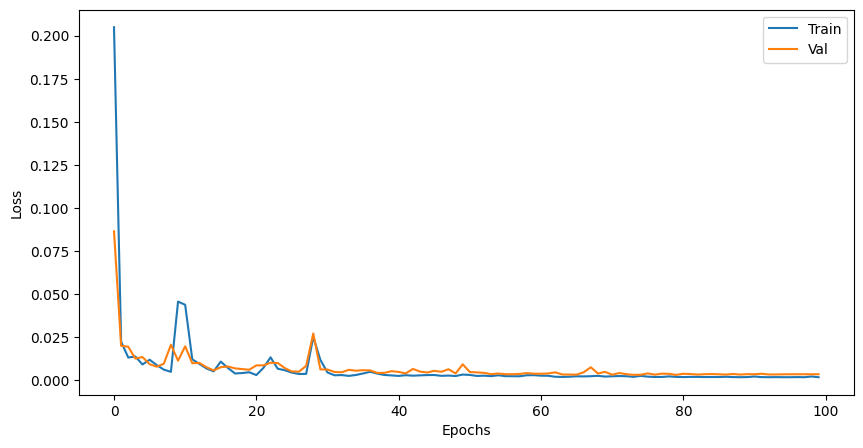

In [925]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

In [926]:
# Load the trained weights
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

pred_value = []
actual_value = []
test_losses = 0


with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features).squeeze(-1)
        pred_value.append(outputs.cpu())
        actual_value.append(labels.cpu())
        loss = criterion(outputs, labels)
        test_losses += loss.item()

avg_test_loss = test_losses / len(test_loader)

print("average test loss: ", round(avg_test_loss, 4))

pred_value = torch.cat(pred_value)
actual_value = torch.cat(actual_value)

average test loss:  0.0013


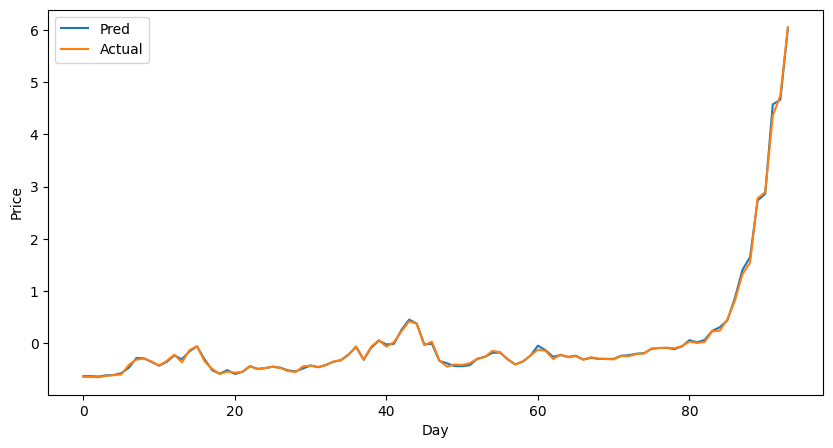

In [927]:
plt.figure(figsize=(10, 5))
plt.plot(pred_value[:])
plt.plot(actual_value[:])
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])

plt.show()

Baseline MSE: 0.0013
Open importance: 0.0628
High importance: 0.0893
Low importance: 0.0715
Close importance: 0.1072
Volume importance: -0.0004


C:\Users\113034531\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36234 (\N{CJK UNIFIED IDEOGRAPH-8D8A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\113034531\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\113034531\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\113034531\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


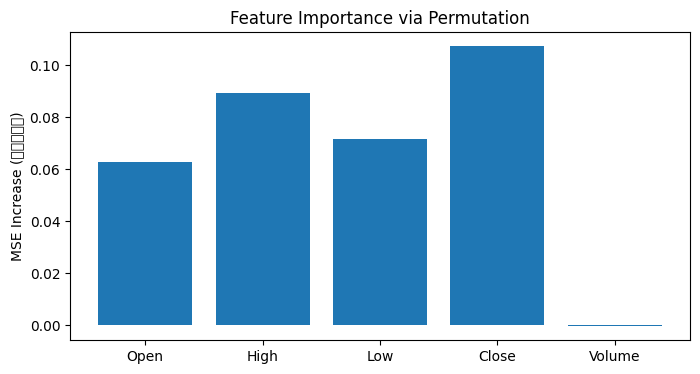

In [928]:
from sklearn.metrics import mean_squared_error

# baseline MSE
baseline_preds = model(x_test.cuda()).squeeze(-1).detach().cpu().numpy()
baseline_mse = mean_squared_error(y_test.numpy(), baseline_preds)
print(f'Baseline MSE: {baseline_mse:.4f}')

import copy

importances = []
feature_names = ['Open', 'High', 'Low', 'Close', 'Volume']
window_size = x_test.shape[1]

for i in range(len(feature_names)):
    x_test_permuted = x_test.clone()
    # 針對所有 window 的第 i 個特徵隨機打亂
    for t in range(window_size):
        idx = i  # 第幾個 feature
        rand_idx = torch.randperm(x_test.shape[0])
        x_test_permuted[:, t, idx] = x_test[rand_idx, t, idx]
    
    preds = model(x_test_permuted.cuda()).squeeze(-1).detach().cpu().numpy()
    permuted_mse = mean_squared_error(y_test.numpy(), preds)
    importance = permuted_mse - baseline_mse
    importances.append(importance)
    print(f'{feature_names[i]} importance: {importance:.4f}')

# 視覺化
plt.figure(figsize=(8, 4))
plt.bar(feature_names, importances)
plt.ylabel("MSE Increase (越高越重要)")
plt.title("Feature Importance via Permutation")
plt.show()
